# Proyecto colaborativo: Reconocimiento de objetos con TensorFlow

## Diego Armando Martinez Florez 20252695006

# Librerias

In [55]:
import os
import cv2
import math
from tqdm import tqdm

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np # Import numpy

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt


# Extracción de los frames



In [56]:
# Definir rutas principales
BASE_DIR = os.getcwd()  # Get the current working directory
RAW_DIR = os.path.join(BASE_DIR, "raw")
PROCESSED_DIR = os.path.join(BASE_DIR, "processed")


# Crear carpeta raw y processed si no existen
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("RAW_DIR:", RAW_DIR)
print("Videos detectados:", os.listdir(RAW_DIR))

BASE_DIR: /content
RAW_DIR: /content/raw
Videos detectados: ['20252695006_mesa.mp4', '20252695006_silla.mp4', '20252695006_pantalla.mp4', '20252695006_nada.mp4', '20252695006_cpu.mp4', '20252695006_teclado.mp4', '20252695006_mouse.mp4']


In [57]:


# Definir rutas principales
BASE_DIR = os.getcwd()  # Get the current working directory
RAW_DIR = os.path.join(BASE_DIR, "raw")
PROCESSED_DIR = os.path.join(BASE_DIR, "processed")

def extract_frames(video_path, output_folder, step=10, min_frames=8):
    """
    Extrae un frame cada 'step' cuadros y asegura al menos 'min_frames' imágenes.
    Los archivos se numeran desde 0001.
    """
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    saved = 0
    frames_to_save = []

    # Calcular índices de frames a guardar
    for i in range(0, frame_count, step):
        frames_to_save.append(i)
    # Asegurar mínimo de frames
    if len(frames_to_save) < min_frames:
        # Generar índices espaciados uniformemente
        if min_frames > 1:
            frames_to_save = [
                int(round(i * (frame_count - 1) / (min_frames - 1)))
                for i in range(min_frames)
            ]
        elif min_frames == 1 and frame_count > 0:
             frames_to_save = [int(frame_count/2)]
        else:
             frames_to_save = []


    # Extraer y guardar frames seleccionados
    current_frame = 0
    idx_to_save = set(frames_to_save)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if current_frame in idx_to_save:
            video_name = os.path.basename(video_path).split('.')[0]
            frame_name = f"{video_name}_{saved+1:04}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_name), frame)
            saved += 1
        current_frame += 1

    cap.release()
    print(f"{os.path.basename(video_path)} → {saved} frames guardados en {output_folder}")

# Extraer frames de cada video en la carpeta raw
video_files = [f for f in os.listdir(RAW_DIR) if f.endswith('.mp4')]

for video_file in tqdm(video_files, desc="Processing videos"):
    video_path = os.path.join(RAW_DIR, video_file)
    output_folder = os.path.join(PROCESSED_DIR, os.path.splitext(video_file)[0])
    extract_frames(video_path, output_folder, step=15, min_frames=8)

Processing videos:  14%|█▍        | 1/7 [00:00<00:04,  1.21it/s]

20252695006_mesa.mp4 → 8 frames guardados en /content/processed/20252695006_mesa


Processing videos:  29%|██▊       | 2/7 [00:01<00:03,  1.49it/s]

20252695006_silla.mp4 → 8 frames guardados en /content/processed/20252695006_silla


Processing videos:  43%|████▎     | 3/7 [00:02<00:02,  1.36it/s]

20252695006_pantalla.mp4 → 8 frames guardados en /content/processed/20252695006_pantalla


Processing videos:  57%|█████▋    | 4/7 [00:03<00:02,  1.10it/s]

20252695006_nada.mp4 → 8 frames guardados en /content/processed/20252695006_nada


Processing videos:  71%|███████▏  | 5/7 [00:04<00:01,  1.16it/s]

20252695006_cpu.mp4 → 8 frames guardados en /content/processed/20252695006_cpu


Processing videos:  86%|████████▌ | 6/7 [00:05<00:00,  1.06it/s]

20252695006_teclado.mp4 → 8 frames guardados en /content/processed/20252695006_teclado


Processing videos: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

20252695006_mouse.mp4 → 8 frames guardados en /content/processed/20252695006_mouse


# Lectura de frames

Se extraen los datos desde el github, para pdoceder con el entrenamiento.

In [58]:
!wget https://github.com/diegomartinezbd/objetos_salon/archive/refs/heads/main.zip

--2025-10-22 06:18:31--  https://github.com/diegomartinezbd/objetos_salon/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/diegomartinezbd/objetos_salon/zip/refs/heads/main [following]
--2025-10-22 06:18:32--  https://codeload.github.com/diegomartinezbd/objetos_salon/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip.1’

main.zip.1              [               <=>  ]   1.15G  29.7MB/s    in 59s     

2025-10-22 06:19:31 (20.0 MB/s) - ‘main.zip.1’ saved [1237503710]



In [59]:
!unzip -q main.zip
!ls objetos_salon-main/processed

replace objetos_salon-main/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace objetos_salon-main/models/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace objetos_salon-main/notebooks/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace objetos_salon-main/processed/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace objetos_salon-main/processed/cpu/20172167090_Cpu_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace objetos_salon-main/processed/cpu/20172167090_Cpu_10.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace objetos_salon-main/processed/cpu/20172167090_Cpu_2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace objetos_salon-main/processed/cpu/20172167090_Cpu_3.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace objetos_salon-main/processed/cpu/20172167090_Cpu_4.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace objetos_salon-main/processed/cpu/20172167090_Cpu_5.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace objetos_salon-main/processed

## Cargando Dataset Propio

In [62]:
import numpy as np

image_data = []
labels = []

for video_dir in os.listdir(PROCESSED_DIR):
    video_path = os.path.join(PROCESSED_DIR, video_dir)
    if os.path.isdir(video_path):
        label = video_dir  # Nombre directorio
        for image_file in os.listdir(video_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_path = os.path.join(video_path, image_file)
                img = cv2.imread(image_path)
                if img is not None:
                    image_data.append(img)
                    labels.append(label)

print(f"Loaded {len(image_data)} images with labels.")

Loaded 56 images with labels.


## Cargando datos de GitHub

In [80]:
import os
import cv2
import numpy as np

github_processed_dir = os.path.join(BASE_DIR, "objetos_salon-main", "processed")

github_image_data = []
github_labels = []

print(f"Loading data from: {github_processed_dir}")
for video_dir in os.listdir(github_processed_dir):
    video_path = os.path.join(github_processed_dir, video_dir)
    # Check if it's a directory and not the README file
    if os.path.isdir(video_path) and video_dir != 'README.md':
        label = video_dir  # Directory name as label
        print(f"Processing directory: {label}")
        for image_file in os.listdir(video_path):
            if image_file.lower().endswith(('.jpg', '.jpeg', '.png')): # Case-insensitive check for image extensions
                image_path = os.path.join(video_path, image_file)
                img = cv2.imread(image_path)
                # Check if the image was successfully loaded
                if img is not None:
                    github_image_data.append(img)
                    github_labels.append(label)
                else:
                    print(f"Warning: Could not read image file: {image_path}")
            elif image_file != 'README.md':
                 print(f"Warning: Skipping non-image file: {os.path.join(video_path, image_file)}")


print(f"Loaded {len(github_image_data)} images with labels from GitHub data.")
print(f"Number of images: {len(github_image_data)}")
print(f"Number of labels: {len(github_labels)}")

Loading data from: /content/objetos_salon-main/processed
Processing directory: pantalla
Processing directory: nada
Processing directory: mesa
Processing directory: cpu
Processing directory: silla
Processing directory: teclado
Processing directory: mouse
Loaded 1054 images with labels from GitHub data.
Number of images: 1054
Number of labels: 1054


# Entrenando Autoencoder

In [63]:
# Pre-procesamiento de imagenes

# Ajustando tamaño de imagenes para simplificar 128x128
IMG_HEIGHT = 128
IMG_WIDTH = 128

image_data_resized = []
for img in image_data:
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    image_data_resized.append(img_resized)

# Convirtiendo lista a arreglo numpy
image_data_np = np.array(image_data_resized)

# Normalizando pixeles
image_data_np = image_data_np.astype('float32') / 255.0


# Definiendo autoencoder
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3) # Assuming color images
input_img = tf.keras.Input(shape=input_shape)

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)

# Compilando autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenando autoencoder

autoencoder.fit(image_data_np, image_data_np,
                epochs=10,
                batch_size=32,
                shuffle=True)

print("Autoencoder training finished.")

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.1170
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.1126
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.1037
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0657
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0389
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0330
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0258
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0232
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0234
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0214
Autoencoder training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


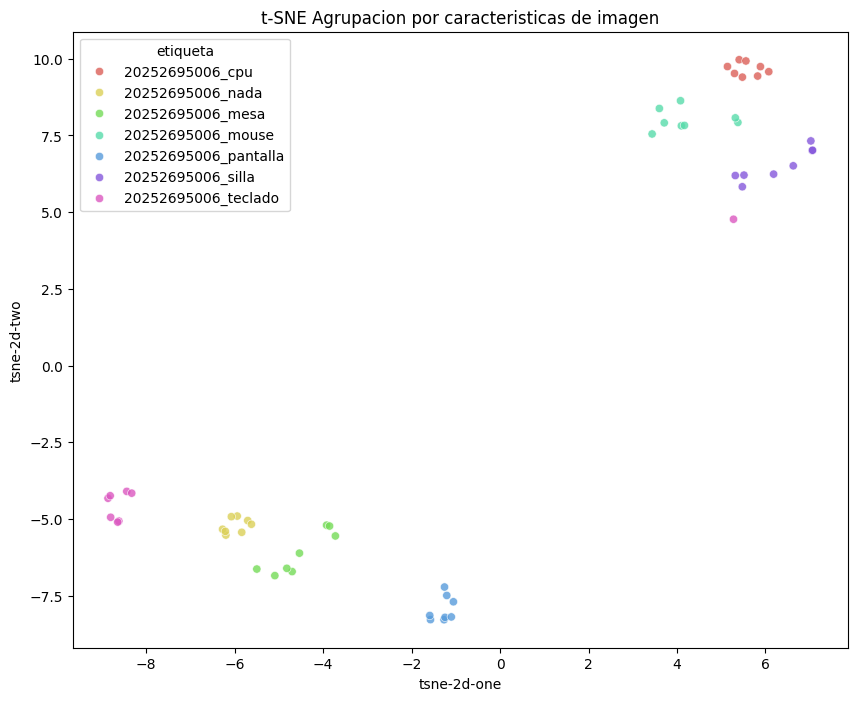

In [64]:
# Remodelar las características para que sean 2D para t-SNE
# La forma actual es (núm. de muestras, altura, ancho, canales)
# Necesitamos aplanar las dimensiones espaciales
num_samples, height, width, channels = image_features.shape
image_features_flat = image_features.reshape(num_samples, height * width * channels)

tsne = TSNE(n_components=2, random_state=42, perplexity=15, n_iter=300)
tsne_results = tsne.fit_transform(image_features_flat)

# Crea un DataFrame para facilitar la representación gráfica
tsne_df = pd.DataFrame(data = tsne_results, columns = ['tsne-2d-one', 'tsne-2d-two'])
tsne_df['etiqueta'] = labels

# Gráfica de resultados
plt.figure(figsize=(10, 8))
import seaborn as sns
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="etiqueta",
    palette=sns.color_palette("hls", len(set(labels))),
    data=tsne_df,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE Agrupacion por caracteristicas de imagen')
plt.show()

In [65]:
# Crear un nuevo modelo que sea solo el codificador
encoder_model = models.Model(inputs=autoencoder.input, outputs=encoded)

# Extraer características usando el modelo del codificador
image_features = encoder_model.predict(image_data_np)

print(f"Extracted features with shape: {image_features.shape}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Extracted features with shape: (56, 16, 16, 128)


In [66]:
# Calcular el tamaño del espacio latente aplanado
latent_space_size = 16 * 16 * 128

print(f"The dimensionality of the flattened latent space is: {latent_space_size}")

The dimensionality of the flattened latent space is: 32768


# CNN

In [67]:
# Remodelar las características de la imagen para que sean 2D
num_samples, height, width, channels = image_features.shape
image_features_flat = image_features.reshape(num_samples, height * width * channels)

# Combinar las etiquetas de ambos conjuntos de datos para que se ajusten al codificador de etiquetas
combined_labels = labels + github_labels

label_encoder = LabelEncoder()
label_encoder.fit(combined_labels)

# Codificar las etiquetas de ambos conjuntos de datos utilizando el codificador ajustado
encoded_labels = label_encoder.transform(labels)
github_encoded_labels = label_encoder.transform(github_labels)


# Dividir los datos en conjuntos de entrenamiento y de prueba (usando los datos para el entrenamiento)
X_train, X_test, y_train, y_test = train_test_split(image_features_flat, encoded_labels, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training features shape: (44, 32768)
Testing features shape: (12, 32768)
Training labels shape: (44,)
Testing labels shape: (12,)


## Define the cnn classifier model

### Subtask:
Create a new CNN model that takes the extracted features as input and has an output layer for classification.


In [68]:
num_classes = len(label_encoder.classes_)

# Definir la capa de entrada para el modelo clasificador
input_layer = Input(shape=(image_features_flat.shape[1],))

# Agregar capas densas
x = Dense(128, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)

# Agregar la capa densa de salida
output_layer = Dense(num_classes, activation='softmax')(x)

# Creando el Modelo
classifier_model = Model(inputs=input_layer, outputs=output_layer)

classifier_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,203,598 (16.04 MB)

 Trainable params: 4,203,598 (16.04 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
classifier_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

## Entrenando modelo cnn


In [70]:
history = classifier_model.fit(X_train, y_train,
                               epochs=10,
                               batch_size=32,
                               validation_split=0.2,
                               validation_data=(X_test, y_test))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.1477 - loss: 2.6710 - val_accuracy: 0.1667 - val_loss: 2.2954
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3617 - loss: 1.7448 - val_accuracy: 0.8333 - val_loss: 0.9800
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6686 - loss: 1.1101 - val_accuracy: 0.6667 - val_loss: 0.8368
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5350 - loss: 0.8235 - val_accuracy: 0.5833 - val_loss: 0.6203
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7699 - loss: 0.4928 - val_accuracy: 0.9167 - val_loss: 0.3245
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9489 - loss: 0.3117 - val_accuracy: 1.0000 - val_loss: 0.2129
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.1876 - val_accuracy: 1.0000 - val_loss: 0.1760
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.1253 - val_accuracy: 0.9167 - val_loss:

# Evaluando

In [77]:
# Evaluando modelo
loss, accuracy = classifier_model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.0793
Test Accuracy: 1.0000


In [78]:
# Verify the lengths of the encoded labels and predicted classes
print(f"Length of github_encoded_labels: {len(github_encoded_labels)}")
print(f"Length of predicted_classes: {len(predicted_classes)}")

Length of github_encoded_labels: 1054
Length of predicted_classes: 1055


## Analizar clasificaciones en datos de GitHub

In [85]:
import pandas as pd
import numpy as np

# Muestra las probabilidades previstas para las algunas imágenes de GitHub
print("Predicted probabilities for the first 10 GitHub images:")

class_names = label_encoder.classes_
predictions_df = pd.DataFrame(github_predictions[:10], columns=class_names)
predictions_df['True Label'] = label_encoder.inverse_transform(github_encoded_labels[:10])

display(predictions_df)

predicted_classes_sample = np.argmax(github_predictions[:10], axis=1)
predicted_labels_sample = label_encoder.inverse_transform(predicted_classes_sample)

print("\nPredicted classes for the first 10 GitHub images:")
print(predicted_labels_sample)

Predicted probabilities for the first 10 GitHub images:


,20252695006_cpu,20252695006_mesa,20252695006_mouse,20252695006_nada,20252695006_pantalla,20252695006_silla,20252695006_teclado,cpu,mesa,mouse,nada,pantalla,silla,teclado,True Label
0,0.009659,0.000279,0.011993,0.000059,6.084711e-07,0.030454,0.947444,0.000107,3.435418e-06,7.292908e-08,7.473345e-09,1.664244e-08,1.571847e-08,1.337358e-07,pantalla
1,0.006939,0.000199,0.006999,0.000021,2.614456e-07,0.026695,0.959075,0.000070,1.369503e-06,3.092850e-08,2.711563e-09,5.657390e-09,6.320044e-09,7.552127e-08,pantalla
2,0.043151,0.001940,0.035476,0.000805,2.558490e-05,0.056717,0.860703,0.001078,9.250030e-05,4.260813e-06,8.596531e-07,1.466116e-06,1.561762e-06,5.775626e-06,pantalla
3,0.073231,0.005730,0.065361,0.004112,2.407234e-04,0.076425,0.769626,0.004360,7.067620e-04,5.981944e-05,1.681903e-05,2.486071e-05,3.146577e-05,7.568004e-05,pantalla
4,0.030234,0.000601,0.022478,0.000200,3.963025e-06,0.034294,0.911861,0.000310,1.565853e-05,4.510144e-07,5.510323e-08,1.018929e-07,1.275845e-07,6.128107e-07,pantalla
5,0.007857,0.000164,0.008551,0.000026,2.294725e-07,0.030909,0.952440,0.000052,1.172011e-06,2.080989e-08,1.570067e-09,3.716669e-09,3.745475e-09,3.906256e-08,pantalla
6,0.011505,0.000253,0.010801,0.000059,6.485905e-07,0.027325,0.949939,0.000113,3.424248e-06,6.649152e-08,7.504840e-09,1.610710e-08,1.711762e-08,1.260736e-07,pantalla
7,0.003521,0.000053,0.003933,0.000008,3.676819e-08,0.012426,0.980034,0.000024,3.123872e-07,3.348048e-09,2.531609e-10,5.988117e-10,7.117890e-10,9.667890e-09,pantalla
8,0.041600,0.001186,0.030533,0.000386,1.103391e-05,0.058512,0.867205,0.000525,3.714560e-05,1.548677e-06,1.965050e-07,3.244315e-07,4.159186e-07,1.681355e-06,pantalla
9,0.117242,0.017199,0.092373,0.009104,1.276485e-03,0.141176,0.606852,0.011014,2.408586e-03,3.896626e-04,1.336808e-04,1.748032e-04,2.067857e-04,4.486570e-04,pantalla



Predicted classes for the first 10 GitHub images:
['20252695006_teclado' '20252695006_teclado' '20252695006_teclado'
 '20252695006_teclado' '20252695006_teclado' '20252695006_teclado'
 '20252695006_teclado' '20252695006_teclado' '20252695006_teclado'
 '20252695006_teclado']


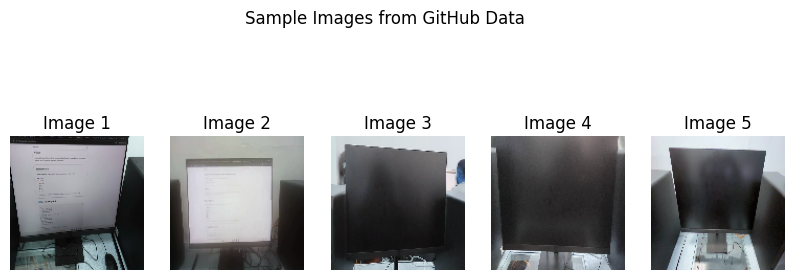

In [86]:
import matplotlib.pyplot as plt

# Mostrando algunas de las imagenes
n_display_images = 5 # Number of images to display

plt.figure(figsize=(10, 4))
for i in range(min(n_display_images, len(github_image_data_np))):
    ax = plt.subplot(1, n_display_images, i + 1)
    plt.imshow(github_image_data_np[i])
    plt.title(f"Image {i+1}")
    plt.axis("off")

plt.suptitle("Sample Images from GitHub Data")
plt.show()

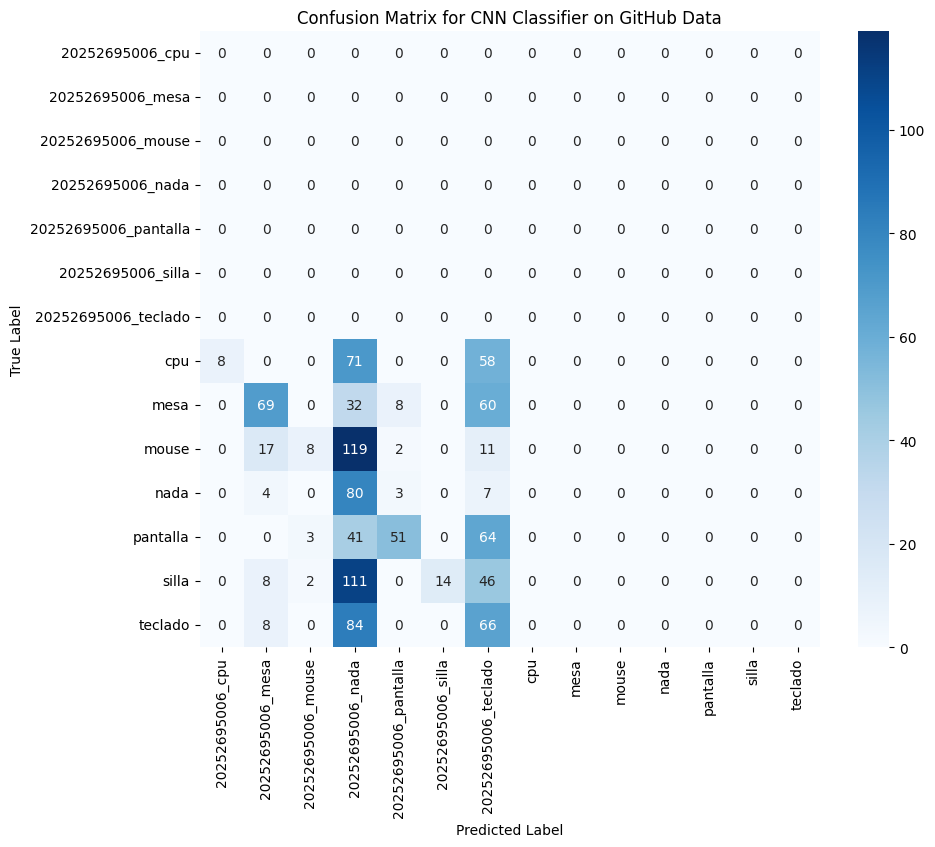

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generando la matreiz de confusion
cm = confusion_matrix(github_encoded_labels, predicted_classes)

class_names = label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for CNN Classifier on GitHub Data')
plt.show()

## Conclusiones

El modelo desarrollado muestra resultados prometedores ya que ha logrado identificar de manera correcta varias de las clases del conjunto de imagenes. Entre sus principales fortalezas se destaca que el modelo reconoce con alta precisión ciertas categorías, como mouse, nada y parcialmente cpu, lo cual evidencia que la red fue capaz de captar caracteristicas visuales relevantes para diferenciar algunos tipos de objetos. Asimismo, se observa un patrón de agrupamiento bien definido en el espacio de características generado por el modelo, lo que indica que el proceso de entrenamiento permitió que la red aprendiera representaciones internas útiles para distinguir entre distintas clases.

Sin embargo, también se identifican algunas debilidades en el desempeño general. En particular, se presentan confusiones importantes entre las clases silla, mouse y teclado. Esto sugiere que los descriptores extraídos por el modelo no logran una separación clara entre objetos que comparten contextos visuales similares, colores cercanos o formas parecidas. Adicionalmente, se observa que las clases visualmente próximas, o aquellas capturadas en condiciones de iluminación o fondo semejantes, tienden a solaparse en el espacio de características, lo que dificulta su correcta clasificación.

## Visualize Reconstructed Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


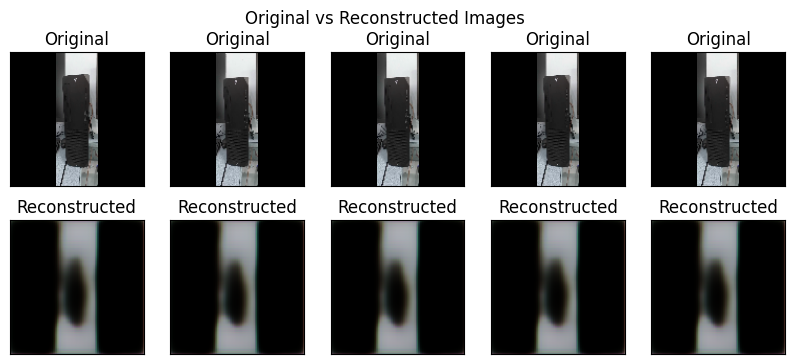

In [40]:
import matplotlib.pyplot as plt

# Get a few sample images from the dataset
n = 5 # Number of images to visualize
sample_images = image_data_np[:n]

# Get the reconstructed images from the autoencoder
reconstructed_images = autoencoder.predict(sample_images)

# Display original and reconstructed images
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    # Ensure the reconstructed image is in the correct format for displaying (e.g., clip values)
    plt.imshow(np.clip(reconstructed_images[i], 0.0, 1.0))
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Original vs Reconstructed Images")
plt.show()

In [45]:
# Save the trained weights of the autoencoder
autoencoder_weights_path = "autoencoder_weights.weights.h5"
autoencoder.save_weights(autoencoder_weights_path)
print(f"Autoencoder weights saved to: {autoencoder_weights_path}")

# Save the trained weights of the CNN classifier
classifier_weights_path = "classifier_weights.weights.h5"
classifier_model.save_weights(classifier_weights_path)
print(f"Classifier weights saved to: {classifier_weights_path}")

Autoencoder weights saved to: autoencoder_weights.weights.h5
Classifier weights saved to: classifier_weights.weights.h5


In [46]:
!ls -lh autoencoder_weights.weights.h5

-rw-r--r-- 1 root root 3.9M Oct 22 05:03 autoencoder_weights.weights.h5


In [47]:
# You can load the weights back into a model with the same architecture like this:
# autoencoder_model_loaded = models.Model(input_img, decoded) # Define the model first
# autoencoder_model_loaded.load_weights("autoencoder_weights.weights.h5")
# print("Autoencoder weights loaded successfully.")